In [1]:
%matplotlib inline

# Data analysis

In this notebook you will find:
- Necessary imports
- Participant age information
- Number of dyslexic parents
- Function to calculate the average erp per class (risk/no risk)
- Frequency domain features
- Connectivity with stimulus and without 

Note: Make sure you run the data analysis notebook before to have the right paths in the `metadata.csv`!

# Imports

Below are the necessary imports for this notebook. mne_connectivity still needs to be added to the environment. 

In [33]:
import mne      # toolbox for analyzing and visualizing EEG data
import os       # using operating system dependent functionality (folders)
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
from ipywidgets import IntSlider, Output
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from math import nan

# Make sure that the 5 imports below are all installed using pip install ... 
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_sensors_connectivity
import pyvista 
import mayavi
import vtk

import sys
sys.path.insert(0, '../eegyolk') # path to helper functions
import helper_functions as hf # library useful for eeg and erp data cleaning
#import initialization_functions #library to import data
import epod_helper

The newest version of mne is necessary to run connectivity plots. If you don't have the latest version, uncomment and run the line below.

In [34]:
# pip install git+https://github.com/mne-tools/mne-python.git

## Load metadata

In the notebook `data_prep_eeg.ipynb` a csv-file `metadata.csv` is created. It is saved in the same folder as this notebook. The csv contains information about the participants and the corresponding eeg and epoch files. 

In [64]:
metadata = pd.read_csv('metadata.csv', sep = ',')

In [54]:
metadata = metadata[:8]

In [65]:
metadata

,eeg_file,ParticipantID,test,sex,age_months,age_months_days,dyslexic_parent,Group_AccToParents,eeg_path,path_epoch,epoch_file
0,101a,101,a,m,20,20;22,m,At risk,F:\Stage\ePODIUM\Data\ePodium_projectfolder\Da...,epochs,101a_epo.fif
1,101b,101,b,m,23,23;16,m,At risk,F:\Stage\ePODIUM\Data\ePodium_projectfolder\Da...,epochs,101b_epo.fif
2,102a,102,a,f,20,20;27,Nee,Control,F:\Stage\ePODIUM\Data\ePodium_projectfolder\Da...,epochs,102a_epo.fif
3,102b,102,b,f,23,23;16,Nee,Control,F:\Stage\ePODIUM\Data\ePodium_projectfolder\Da...,epochs,102b_epo.fif
4,103a,103,a,f,20,20;23,m,At risk,F:\Stage\ePODIUM\Data\ePodium_projectfolder\Da...,epochs,103a_epo.fif
...,...,...,...,...,...,...,...,...,...,...,...
80,146a,146,a,m,18,18;27,Nee,Control,F:\Stage\ePODIUM\Data\ePodium_projectfolder\Da...,epochs,146a_epo.fif
81,146b,146,b,m,21,21;19,Nee,Control,F:\Stage\ePODIUM\Data\ePodium_projectfolder\Da...,epochs,146b_epo.fif
82,147a,147,a,m,19,19;21,Nee,Control,F:\Stage\ePODIUM\Data\ePodium_projectfolder\Da...,epochs,147a_epo.fif
83,148a,148,a,m,18,18;6,m,At risk,F:\Stage\ePODIUM\Data\ePodium_projectfolder\Da...,epochs,148a_epo.fif


## Participant information

The value to classify will be whether the participant is at risk for dyslexia or not. The age distribution for both groups is plotted below.

count    85.000000
mean     19.894118
std       2.425183
min      15.000000
25%      18.000000
50%      20.000000
75%      22.000000
max      25.000000
Name: age_months, dtype: float64

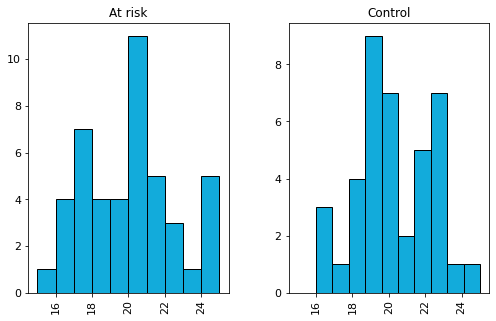

In [66]:
hist = metadata.hist(column='age_months',by='Group_AccToParents',color='#12ABDB',sharex=True, figsize=(8,5), xlabelsize=11, ylabelsize=11,bins=10,ec='black')
metadata['age_months'].describe()

Count of the gender for both groups. 

In [67]:
metadata.groupby('Group_AccToParents')['sex'].value_counts()

Group_AccToParents  sex
At risk             m      25
                    f      20
Control             m      24
                    f      16
Name: sex, dtype: int64

Count of whether the mom or dad is dyslexic or not. 

In [68]:
metadata.groupby('Group_AccToParents')['dyslexic_parent'].value_counts()

Group_AccToParents  dyslexic_parent
At risk             m                  26
                    f                  15
                    mf                  4
Control             Nee                40
Name: dyslexic_parent, dtype: int64

## ERP per group

This function is able to calculate the average erp for a specific condition. The function needs a dataframe like `metadata.csv` which contains the epoch files and the participants characteristics. It also needs as input the characteristic we are interested in and a single value of this characteristic. For example if we want to look at the average erp for the children who are at risk, the group will be the column (feature) containing the values at risk or control and the value will be 'at risk'. The function also needs the event dictionary in order to average the epochs over multiple participants. 

In [82]:
event_dictionary = epod_helper.event_dictionary

def data_analysis(dataframe, group, value, event_dictionary):
    epochs = []
    evoked_pp = []
    dataframe = dataframe.loc[metadata[group] == value]
    evokeds = []
    
    for index, file in dataframe.iterrows():
        print(f"Checking out file: {file['epoch_file']}")
        path = os.path.join(file['path_epoch'], file['epoch_file'])
        epoch = mne.read_epochs(path, preload=False)
        epochs.append(epoch)
    
    for i in range(len(epochs)): 
        evoked = evoked_responses(epochs[i], event_dictionary)
        evokeds.append(evoked)
    
    for i in range(len(evokeds)):
        grand_avg = mne.grand_average(evokeds[i])
        evoked_pp.append(grand_avg)
    
    grand_evoked = mne.grand_average(evoked_pp)
    
    return grand_evoked.plot(spatial_colors=True)

In [83]:
atrisk = data_analysis(metadata, group='Group_AccToParents', value = 'At risk', event_dictionary = epod_helper.event_dictionary)

Checking out file: 101a_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\101a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2266 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2266 events and 2049 original time points ...


AttributeError: 'numpy.ndarray' object has no attribute 'info'

Checking out file: 102a_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\102a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2389 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 102b_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\102b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 113a_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\113a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
765 matching events found
No baseline correction applied
0 pr

Checking out file: 135b_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\135b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
1220 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 136a_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\136a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
1220 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 136b_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\136b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2266 matching events found
No baseline correction applied
0 p

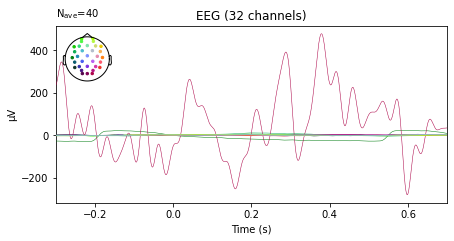

In [71]:
control = data_analysis(metadata, group='Group_AccToParents', value = 'Control', event_dictionary = epod_helper.event_dictionary)

In [72]:
test_a = data_analysis(metadata, group='test', value = 'a', event_dictionary = epod_helper.event_dictionary)

Checking out file: 101a_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\101a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2266 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 102a_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\102a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2389 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 103a_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\103a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2208 matching events found
No baseline correction applied
0 p

Checking out file: 128a_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\128a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
1220 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 129a_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\129a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2266 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 130a_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\130a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2389 matching events found
No baseline correction applied
0 p

ValueError: cannot reshape array of size 0 into shape (32,2049)

Checking out file: 101b_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\101b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 102b_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\102b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 103b_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\103b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2521 matching events found
No baseline correction applied
0 p

Checking out file: 131b_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\131b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2248 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 132b_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\132b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 133b_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\133b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2428 matching events found
No baseline correction applied
0 p

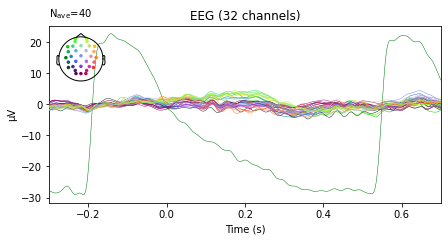

In [73]:
test_b = data_analysis(metadata, group='test', value = 'b', event_dictionary = epod_helper.event_dictionary)

## Connectivity 

In [ ]:
dataframe = metadata
epochs = []
for index, file in dataframe.iterrows():
    print(f"Checking out file: {file['epoch_file']}")
    path = os.path.join(file['path_epoch'], file['epoch_file'])
    epoch = mne.read_epochs(path, preload=False)
    epochs.append(epoch)

Computing eeg connectivity

In [ ]:
def data_connectivity(dataframe, group, value):
    epochs = []
    dataframe = dataframe.loc[metadata[group] == value]
    
    for index, file in dataframe.iterrows():
        print(f"Checking out file: {file['epoch_file']}")
        path = os.path.join(file['path_epoch'], file['epoch_file'])
        epoch = mne.read_epochs(path, preload=False)
        epochs.append(epoch)
    
    epochs_con = mne.concatenate_epochs(epochs)
    
    fmin, fmax = 4., 9.
    sfreq = epochs_con.info['sfreq']  # the sampling frequency
    tmin = 0.0  # exclude the baseline period
    
    con = spectral_connectivity_epochs(
        epochs_con, method='pli', mode='multitaper', fmin=fmin, fmax=fmax,
        faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)

    # Now, visualize the connectivity in 3D:
    
    return plot_sensors_connectivity(epochs_con.info, con.get_data(output='dense')[:, :, 0]), spectral_connectivity_epochs(
        epochs_con, method='pli', mode='multitaper', fmin=fmin, fmax=fmax,
        faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)

In [ ]:
connectivityplot_atrisk, connections_atrisk = data_connectivity(metadata, group='Group_AccToParents', value = 'At risk')

In [ ]:
connections_atrisk = connections_atrisk.get_data(output='dense')[:, :, 0]
matrix = pd.DataFrame(connections_atrisk)
matrix

In [ ]:
connectivityplot_control, connections_control = data_connectivity(metadata, group='Group_AccToParents', value = 'Control')

In [ ]:
connections_control = connections_control.get_data(output='dense')[:, :, 0]
matrix = pd.DataFrame(connections_control)
matrix